# Name: Rediet Ferew
# ID: UGR/1415/12
> **This project aims to build a model for image generation specifically for anime face images. The animefacedataset -> [https://www.kaggle.com/datasets/splcher/animefacedataset/](http://) which is available on kaggle is utilized. The detail process is explained below. The number of epochs should have been high but despite my continuous attempts I have been interrputed by internet connection and I haven't been able to produce a robust model for image generation. This model has taken almost 4hrs to train.**

# Custom Dataset Representation
**AnimeFaceDataset class is defined to represent a dataset of anime faces, utilizing a specified root directory and an optional transformation function. The images are converted to RGB format, and if transformations are specified, they are applied accordingly**

In [15]:
#to manipulate file paths and list files in the kaggle directory
import os 
#for image processing tasks
from PIL import Image 

#for handling datasets and creating data loaders for efficient batch processing during training.
from torch.utils.data import Dataset, DataLoader

# for common image transformations
import torchvision.transforms as transforms

# This class will be used to represent the dataset of anime faces.
class AnimeFaceDataset(Dataset):
    
    #constructor method for the AnimeFaceDataset class
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)
    
    #returns the length of the dataset
    def __len__(self):
        return len(self.file_list)
    
    #used to get an item from the dataset given an index 
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# Dataset Loader

In [16]:
#creates an instance of the AnimeFaceDataset class, specifying the root directory where the images are located 
dataset = AnimeFaceDataset(root_dir='/kaggle/input/animefacedataset/images', transform=transforms.Compose([
    # Resizes the image to have a height and width of 64 pixels
    transforms.Resize((64, 64)),
    # Converts the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalizes the tensor by subtracting the mean (0.5, 0.5, 0.5) and dividing by the standard deviation (0.5, 0.5, 0.5)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization as needed
]))
#used to efficiently load and batch the data during training
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)



# Generator Model
**The generator takes a latent vector of size latent_size and transforms it through a series of transposed convolutional layers, gradually upsampling the input. The architecture includes batch normalization and ReLU activation functions to enhance training stability. The final layer produces an RGB image with three channels, and the Tanh activation function is applied to ensure output values are within the range [-1, 1].**

In [17]:
import torch # Imports the PyTorch library
import torch.nn as nn #Imports the neural network module from PyTorch
import torch.optim as optim #Imports the optimization module from PyTorch
import torchvision.utils as vutils #Imports utility functions from torchvision
import matplotlib.pyplot as plt # Imports the matplotlib library for creating plots and visualizations

#Class that represents the generator component of a Generative Adversarial Network (GAN)
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #transforms the input latent vector of size latent_size into a 4x4 feature map with 512 channels
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            #transposed convolutional layer that upsamples the input to 256 channels
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            #transposed convolutional layer that upsamples the input to 128 channels
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            #transposed convolutional layer that upsamples the input to 3 channels -> RGB
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)



# Discriminator Model

**The discriminator processes input images through a series of convolutional layers, gradually reducing spatial dimensions and increasing the number of channels. Leaky ReLU activation functions and batch normalization enhance the model's ability to capture features and promote stable training. The final layer acts as a binary classifier, outputting a single-channel prediction indicating whether the input image is real or generated by the generator. The Sigmoid activation function is applied to produce probability scores.**

In [18]:
#class that represents the discriminator component of a Generative Adversarial Network (GAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #layer that scans through the input image to detect features
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            #layer that increases the number of channels from 128 to 256
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            #layer that increases the number of channels from 256 to 512
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # layer that reduces the number of channels to 1, producing a single-channel output 
            # classifier layer -> whether the input image is real or fake
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Hyperparameters

In [29]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_size = 100
lr = 0.0002
betas = (0.5, 0.999)
epochs = 10

# Training Process
**A Generative Adversarial Network (GAN) is trained on an animefacedataset dataset using PyTorch. The generator (netG) and discriminator (netD) models are initialized along with the Binary Cross Entropy Loss criterion and Adam optimizers. The training loop iterates through epochs, where the discriminator is trained on both real and fake data, and the generator is trained to generate realistic data to fool the discriminator. The progress, including discriminator and generator losses, is printed at intervals. Generated images are saved at the end of each epoch, providing a visual representation of the model's learning progress. The training process aims to improve the generator's ability to create realistic images that are indistinguishable from genuine data, while the discriminator evolves to effectively distinguish between real and fake samples.**

[0/10][0/994] Loss_D: 1.4130 Loss_G: 4.3682 D(x): 0.4881 D(G(z)): 0.4851 / 0.0134
[0/10][100/994] Loss_D: 0.0135 Loss_G: 6.8106 D(x): 0.9928 D(G(z)): 0.0061 / 0.0013
[0/10][200/994] Loss_D: 0.0048 Loss_G: 6.6872 D(x): 0.9979 D(G(z)): 0.0027 / 0.0014
[0/10][300/994] Loss_D: 0.0019 Loss_G: 7.5954 D(x): 0.9988 D(G(z)): 0.0007 / 0.0006
[0/10][400/994] Loss_D: 0.0007 Loss_G: 8.1341 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[0/10][500/994] Loss_D: 0.0007 Loss_G: 8.0645 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003
[0/10][600/994] Loss_D: 0.0004 Loss_G: 9.0919 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[0/10][700/994] Loss_D: 0.0004 Loss_G: 9.2945 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[0/10][800/994] Loss_D: 0.0003 Loss_G: 9.2380 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[0/10][900/994] Loss_D: 0.0002 Loss_G: 9.3899 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[1/10][0/994] Loss_D: 0.0002 Loss_G: 9.5165 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[1/10][100/994] Loss_D: 0.0002 Loss_G: 9.6921 D(x): 0.9999 D(G(z)): 0.0001 / 0.0

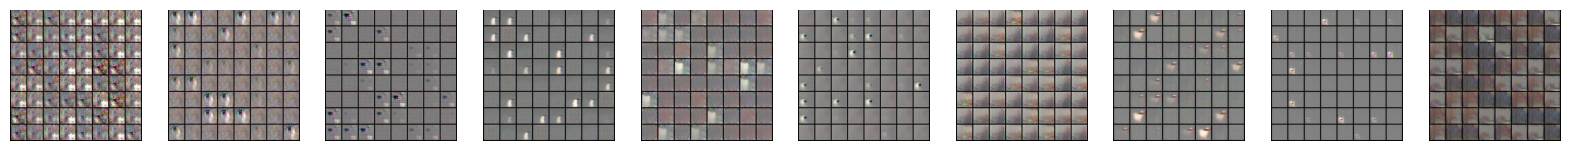

In [30]:
# Initialize generator model
netG = Generator(latent_size)
# Initialize discriminator model
netD = Discriminator()

#Binary Cross Entropy Loss
criterion = nn.BCELoss()
#Adam optimizer 
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=betas)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=betas)

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        #Fetches a batch of real images
        real_data = data
        batch_size = real_data.size(0)
        
        # Creates a tensor filled with 1.0 to represent real labels
        real_label = torch.full((batch_size, 1, 1, 1), 1.0)
        # Creates a tensor filled with 0.0 to represent fake labels
        fake_label = torch.full((batch_size, 1, 1, 1), 0.0)

        # Clears the gradients of the Discriminator before computing gradients.
        netD.zero_grad()
        # Passes real data through the Discriminator
        output = netD(real_data)
        # Calculates the loss for real data
        errD_real = criterion(output, real_label.expand_as(output))  
        # Backpropagates the gradients
        errD_real.backward()
        # Computes the mean output
        D_x = output.mean().item()


        # Generates random noise
        noise = torch.randn(batch_size, latent_size, 1, 1)
        # Passes fake data through the Discriminator
        fake_data = netG(noise)
        output = netD(fake_data.detach())
        
        # Calculates the loss for fake data
        errD_fake = criterion(output, fake_label)
        # Backpropagates the gradients
        errD_fake.backward()
        # Computes the mean output for fake data
        D_G_z1 = output.mean().item()
        # Combines the losses for real and fake data
        errD = errD_real + errD_fake
        # Updates the Discriminator's parameters
        optimizerD.step()

        # Clears the gradients of the Generator before computing gradients
        netG.zero_grad()
        # Passes fake data through the Discriminator
        output = netD(fake_data)
        # Calculates the Generator's loss
        errG = criterion(output, real_label)
        # Backpropagates the gradients through the Generator
        errG.backward()
        # Computes the mean output for the fake data through the updated Discriminator
        D_G_z2 = output.mean().item()
        # Updates the Generator's parameters
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # SPrints the discriminator and generator losses, and the mean outputs for real and fake data, at specified intervals
    with torch.no_grad():
        fake = netG(torch.randn(64, latent_size, 1, 1))
        vutils.save_image(fake, f'fake_samples_epoch_{epoch + 1}.png', normalize=True)

# Visualize generated images
img_list = [f'fake_samples_epoch_{i + 1}.png' for i in range(epochs)]

# Plot the generated images
fig, axs = plt.subplots(1, epochs, figsize=(epochs * 2, 2))
for epoch, ax in zip(range(epochs), axs):
    img = plt.imread(img_list[epoch])
    ax.imshow(img)
    ax.axis('off')
plt.show()


In [31]:
torch.save(netG.state_dict(), 'gan_model.pth')

In [32]:
netG = Generator(latent_size)
netG.load_state_dict(torch.load('//kaggle/working/gan_model.pth'))

<All keys matched successfully>

# Sample Generation

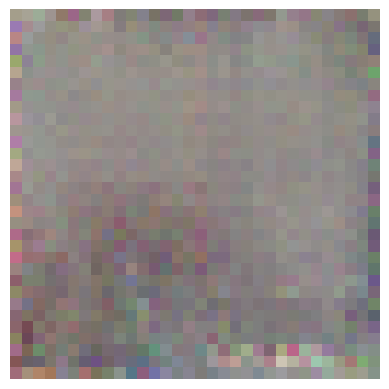

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

with torch.no_grad():
    random_noise = torch.randn(1, latent_size, 1, 1)
    generated_image = netG(random_noise).squeeze().cpu().numpy()
    generated_image = (generated_image + 1) / 2.0  # Unnormalize the image

    
    generated_image = generated_image.transpose(1, 2, 0)

    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()
